In [65]:
import pandas as pd
import quandl
import pandas_datareader.data as web

from datetime import datetime as dt
from functools import reduce

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import matplotlib.pylab as pylab

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Portfolio allocation

## Sharpe ratio

Sharpe ratio let's us understand the relation between stock return and its volatility.

It's defined by the following formula:

$$\Large S = \frac{R_p - R_f}{\sigma_p}$$

where:

- $R_p$ is expected portfolio return

- $R_f$ is a **risk-free return**

- $\sigma_p$ is portfolio STD.

***Risk-free return*** is a return the you'd get if you'd put your money into an (ultra-safe) investment (savings account, LIBOR, bonds) instead of stock. Essentially, today it's `0` in most cases.

Sharpe ratio was originally thought as a yearly metric. To annualize data at different sampling rate, we can multiply Sharpe ratio by K:

* daily: $K = \sqrt{252}$
* weekly: $K = \sqrt{52}$
* monthly: $K = \sqrt{12}$

This results in the following formula:

$$\Large S = K\frac{R_p - R_f}{\sigma_p}$$

Though, not everyone agrees that this anualization works: https://www.researchgate.net/publication/228139699_The_Statistics_of_Sharpe_Ratios

## Define helper funcs

In [3]:
# Define periods
def periods(start, end):
    start = start.split('-')
    end   = end.split('-')
    return dt(int(start[0]), int(start[1]), int(start[2])), dt(int(end[0]), int(end[1]), int(end[2]))

In [49]:
def plot_series(series, labels = None, title = None, lw = 1, alpha = .7):
    
    if type(series) != list:
        
        plt.figure(figsize = (15, 6))
        plt.plot(series, label = labels, lw = lw)
        plt.legend()
        plt.title(title)
        plt.xticks(rotation = 45)
        plt.plot()
    
    else:
        
        plt.figure(figsize = (15, 6))
        
        if type(labels) != list:
            labels = [x for x in range(len(series))]
            
        for serie, label in zip(series, labels):
            
            plt.plot(serie, label = label, alpha = alpha, lw = lw)
        
        plt.xticks(rotation = 45)
        plt.legend()
        plt.title(title)
        plt.plot()

In [122]:
def sharpe_ratio(daily_return, k = 1, no_risk_return = 0):
    return k**.5 * ((daily_return.mean() - no_risk_return) / daily_return.std())

## Get the data

In [14]:
start, end = periods('2017-01-01', '2020-01-01')

In [13]:
# Get the data - AAPL Close (11) column 
# aapl = quandl.get('WIKI/AAPL.11', start_date = start, end_date = end)

In [20]:
aapl = web.DataReader('AAPL', 'stooq', start, end).sort_index().Close
csco = web.DataReader('CSCO', 'stooq', start, end).sort_index().Close
amzn = web.DataReader('AMZN', 'stooq', start, end).sort_index().Close
ibm  = web.DataReader('IBM', 'stooq', start, end).sort_index().Close

## Build a portfolio

In [73]:
stock_df = pd.DataFrame()

### Normed returns

In [74]:
# Compute normed returns
for stock, name in zip([aapl, csco, amzn, ibm], ['AAPL', 'CSCO', 'AMZN', 'IBM']):
    stock_df[name] = stock
    stock_df[f'{name}_normed_ret'] = stock / stock.iloc[0]

Now, let's assume that our portfolio will have a following structure:

* 30% AAPL
* 20% CSCO
* 40% AMZN
* 10% IBM

### Allocation

In [96]:
# Compute allocations
for col in stock_df.columns:
    for name, allo in zip(['AAPL', 'CSCO', 'AMZN', 'IBM'], [.3, .2, .4, .1]):
        if (name in col) and ('_normed_ret' in col):
            stock_df[f'{name}_allocation'] = stock_df[col] * allo

In [76]:
stock_df.head()

,AAPL,AAPL_normed_ret,CSCO,CSCO_normed_ret,AMZN,AMZN_normed_ret,IBM,IBM_normed_ret,AAPL_allocation,CSCO_allocation,AMZN_allocation,IBM_allocation
Date,,,,,,,,,,,,
2015-01-12,100.370,1.000000,23.957,1.000000,291.41,1.000000,128.27,1.000000,0.300000,0.200000,0.400000,0.100000
2015-01-13,101.290,1.009166,24.001,1.001837,294.74,1.011427,128.57,1.002339,0.302750,0.200367,0.404571,0.100234
2015-01-14,100.900,1.005280,23.846,0.995367,293.27,1.006383,127.74,0.995868,0.301584,0.199073,0.402553,0.099587
2015-01-15,98.145,0.977832,23.410,0.977167,286.95,0.984695,126.73,0.987994,0.293350,0.195433,0.393878,0.098799
2015-01-16,97.374,0.970150,23.641,0.986810,290.74,0.997701,128.81,1.004210,0.291045,0.197362,0.399080,0.100421


### Position values

In [77]:
# Compute position values for total investment
investment = 20000

for col in stock_df.columns:
    for name in ['AAPL', 'CSCO', 'AMZN', 'IBM']:
        if (name in col) and ('_allocation' in col):
            stock_df[f'{name}_pos_val'] = stock_df[col] * investment
        

In [78]:
stock_df.head()

,AAPL,AAPL_normed_ret,CSCO,CSCO_normed_ret,AMZN,AMZN_normed_ret,IBM,IBM_normed_ret,AAPL_allocation,CSCO_allocation,AMZN_allocation,IBM_allocation,AAPL_pos_val,CSCO_pos_val,AMZN_pos_val,IBM_pos_val
Date,,,,,,,,,,,,,,,,
2015-01-12,100.370,1.000000,23.957,1.000000,291.41,1.000000,128.27,1.000000,0.300000,0.200000,0.400000,0.100000,6000.000000,4000.000000,8000.000000,2000.000000
2015-01-13,101.290,1.009166,24.001,1.001837,294.74,1.011427,128.57,1.002339,0.302750,0.200367,0.404571,0.100234,6054.996513,4007.346496,8091.417590,2004.677633
2015-01-14,100.900,1.005280,23.846,0.995367,293.27,1.006383,127.74,0.995868,0.301584,0.199073,0.402553,0.099587,6031.682774,3981.466795,8051.062077,1991.736181
2015-01-15,98.145,0.977832,23.410,0.977167,286.95,0.984695,126.73,0.987994,0.293350,0.195433,0.393878,0.098799,5866.992129,3908.669700,7877.560825,1975.988150
2015-01-16,97.374,0.970150,23.641,0.986810,290.74,0.997701,128.81,1.004210,0.291045,0.197362,0.399080,0.100421,5820.902660,3947.238803,7981.606671,2008.419740


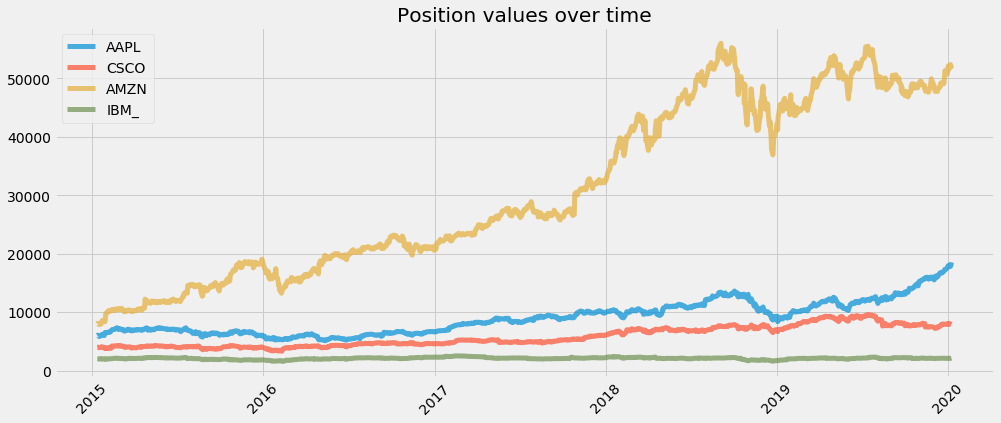

In [79]:
# Plot position values
plot_series([stock_df[col] for col in stock_df.columns if '_pos_val' in col],
            [col[:4] for col in stock_df.columns if '_pos_val' in col],
            'Position values over time',
            lw = 5)

### Portfolio returns

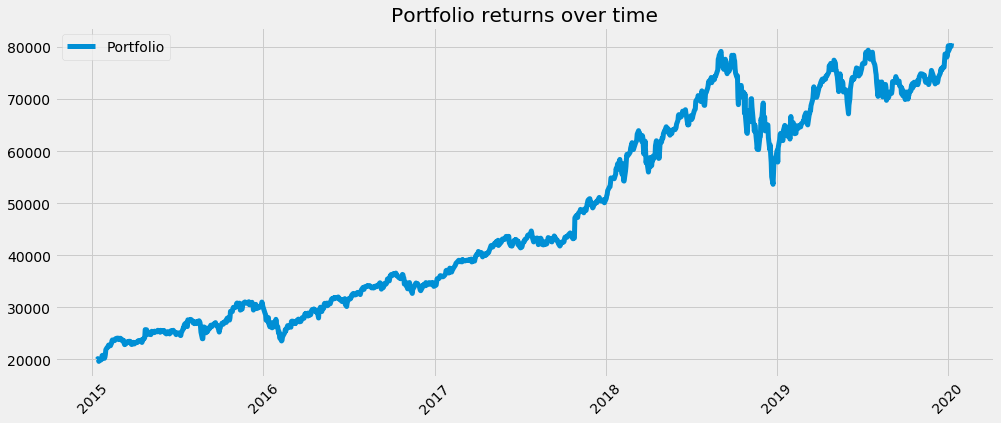

In [80]:
# Plot sum(pos_val)
sum_val = sum([stock_df[col] for col in stock_df.columns if '_pos_val' in col])

plot_series(sum_val, 'Portfolio', 'Portfolio returns over time', lw = 5)

In [90]:
# Let's compute total position
stock_df['total_pos_val'] = sum([stock_df[col] for col in stock_df.columns if '_pos_val' in col])

### Daily portfolio returns

In [92]:
# Let's compute daily returns
stock_df['daily_ret'] = stock_df.total_pos_val.pct_change(1)

In [97]:
stock_df.head()

,AAPL,AAPL_normed_ret,CSCO,CSCO_normed_ret,AMZN,AMZN_normed_ret,IBM,IBM_normed_ret,AAPL_allocation,CSCO_allocation,AMZN_allocation,IBM_allocation,AAPL_pos_val,CSCO_pos_val,AMZN_pos_val,IBM_pos_val,total_pos_val,daily_ret
Date,,,,,,,,,,,,,,,,,,
2015-01-12,100.370,1.000000,23.957,1.000000,291.41,1.000000,128.27,1.000000,0.300000,0.200000,0.400000,0.100000,6000.000000,4000.000000,8000.000000,2000.000000,20000.000000,NaN
2015-01-13,101.290,1.009166,24.001,1.001837,294.74,1.011427,128.57,1.002339,0.302750,0.200367,0.404571,0.100234,6054.996513,4007.346496,8091.417590,2004.677633,20158.438232,0.007922
2015-01-14,100.900,1.005280,23.846,0.995367,293.27,1.006383,127.74,0.995868,0.301584,0.199073,0.402553,0.099587,6031.682774,3981.466795,8051.062077,1991.736181,20055.947827,-0.005084
2015-01-15,98.145,0.977832,23.410,0.977167,286.95,0.984695,126.73,0.987994,0.293350,0.195433,0.393878,0.098799,5866.992129,3908.669700,7877.560825,1975.988150,19629.210804,-0.021277
2015-01-16,97.374,0.970150,23.641,0.986810,290.74,0.997701,128.81,1.004210,0.291045,0.197362,0.399080,0.100421,5820.902660,3947.238803,7981.606671,2008.419740,19758.167874,0.006570


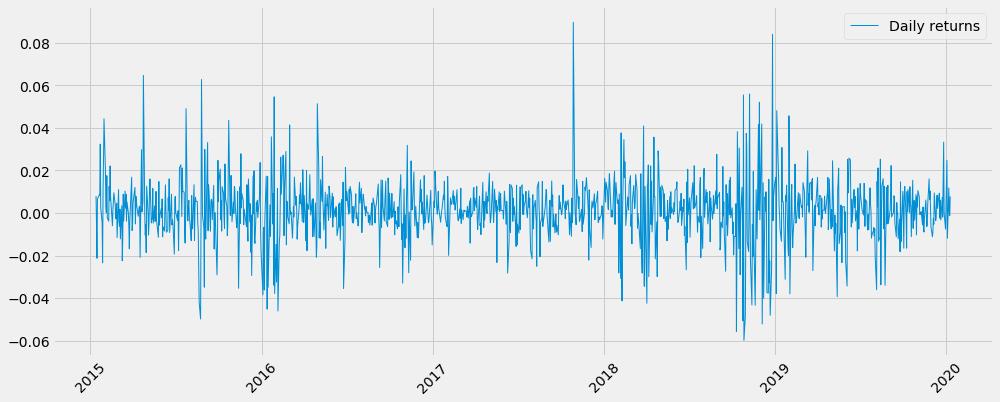

In [95]:
plot_series(stock_df.daily_ret, 'Daily returns', lw = 1)

In [100]:
stock_df.daily_ret.sum(), stock_df.daily_ret.mean(), stock_df.daily_ret.std()

(1.5261171536003648, 0.0012140947920448422, 0.014399602045156175)

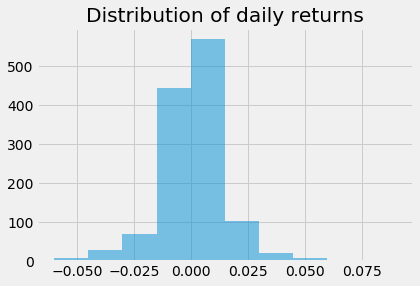

In [103]:
# Get a hist of daily returns
plt.hist(stock_df.daily_ret.dropna(axis = 0), alpha = .5)
plt.title('Distribution of daily returns')
plt.show()

### Cumulative (total) return

In [116]:
c_ret = 100 * (stock_df.total_pos_val[-1] / stock_df.total_pos_val[0] - 1)

In [117]:
print(f'Your total return on investment is {c_ret:.2f}%')

Your total return on investment is 303.66%


Hell of a return! Nice!

### Sharpe ratio

In [125]:
sharpe_ratio(stock_df.daily_ret)

0.0843144684302749

In [126]:
# Annualize it 
sharpe_ratio(stock_df.daily_ret, k = 255)      # 255 trading days in a year

1.346394089634738

One heuristic says that **Sharpe ratio** > 1 is acceptable to good for investors.
It depends on their risk tolerance. 

Ratio $>2$ is usually interpreted as **very good** and $3$ or higher is considered **excellent**.